<a href="https://colab.research.google.com/github/MichalMichniak/pytorch_projects/blob/main/irys_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [442]:
import torch
print(torch.__version__)
import torch.nn as nn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

1.13.1+cpu


## Data manipulation

In [443]:
irys_data = load_iris()
data = irys_data.data
target = irys_data.target
ft_labels = irys_data.feature_names
print("target data type:",target.dtype)

target data type: int32


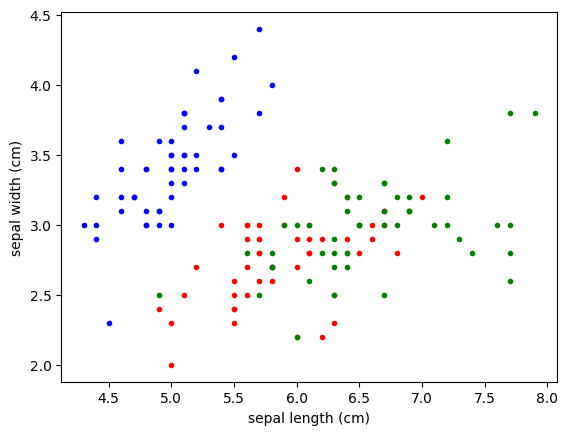

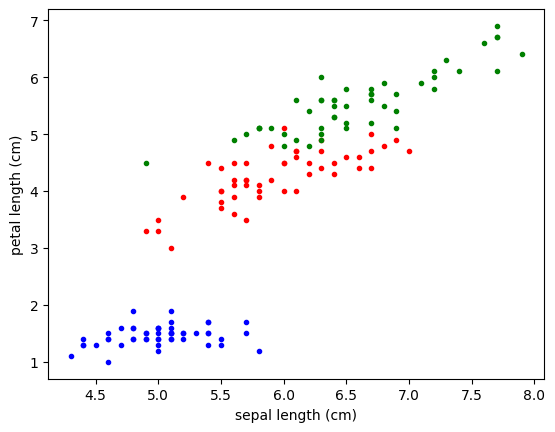

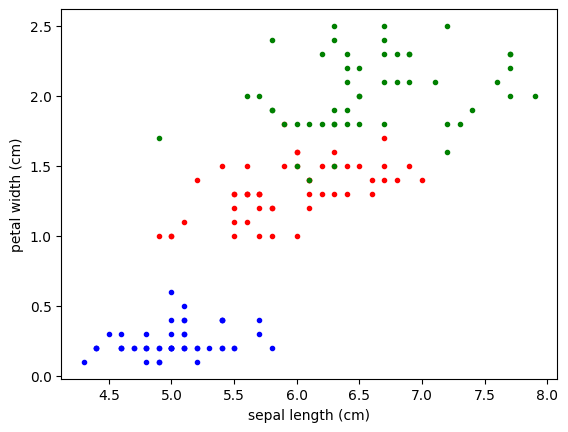

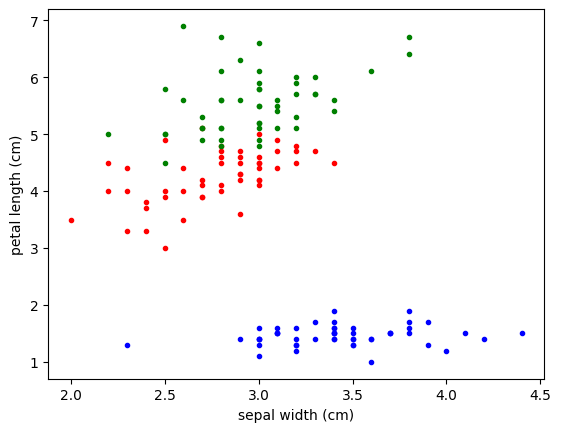

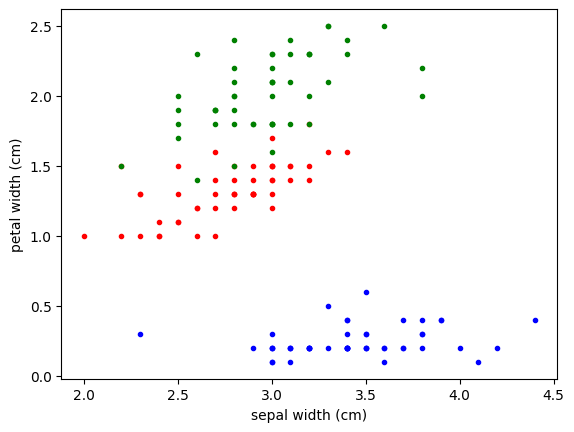

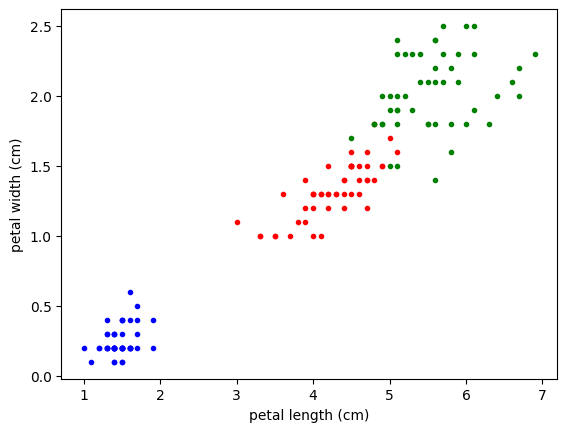

In [444]:
### visualisation of data
for i in range(len(ft_labels)):
    for j in range(i+1,len(ft_labels)):
        for k in range(len(data[:,i])):
            if target[k] == 0:
                plt.plot(data[k,i],data[k,j], 'b.')
            elif target[k] == 1:
                plt.plot(data[k,i],data[k,j], 'r.')
            else:
                plt.plot(data[k,i],data[k,j], 'g.')
        plt.xlabel(ft_labels[i])
        plt.ylabel(ft_labels[j])
        plt.show()

In [445]:
#data standarization
scaler = StandardScaler()
standarizated_data = scaler.fit_transform(data)

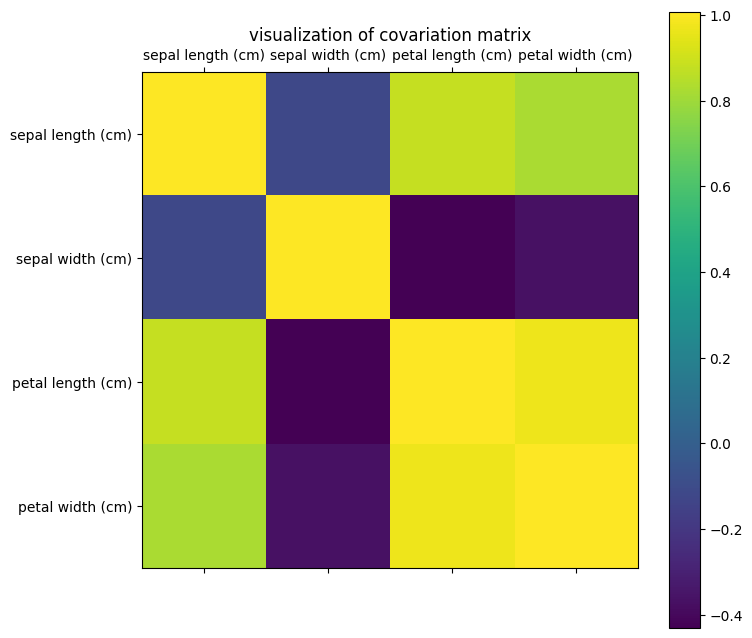

In [446]:

covariation_matrix = np.cov(standarizated_data.T)
fig = plt.figure()
axes = fig.add_subplot(111)
fig.set_size_inches([8,8])
mtsh = axes.matshow(covariation_matrix)
fig.colorbar(mtsh)
axes.set_xticks([i for i in range(len(ft_labels))], ft_labels)
axes.set_yticks([i for i in range(len(ft_labels))], ft_labels)
axes.set_title("visualization of covariation matrix")
plt.show()

from standarized covariance matrix we see that petal width and petal length are highly correlated and both of them are slightly correlated with sepal length. So those features have a lot of the mutual inforamtion. So different highly correlated features may highly influence model with same information 

In [447]:
# reduction of dimentionality
data_tensor = torch.tensor(standarizated_data)
U,S,V = torch.pca_lowrank(data_tensor)
print("singular values:",S)
print("feature vectors:",V[:,:3])
V = V[:,:3]
new_dataset = torch.matmul(data_tensor,V)

singular values: tensor([20.9231, 11.7092,  4.6919,  1.7627], dtype=torch.float64)
feature vectors: tensor([[-0.5211, -0.3774, -0.7196],
        [ 0.2693, -0.9233,  0.2444],
        [-0.5804, -0.0245,  0.1421],
        [-0.5649, -0.0669,  0.6343]], dtype=torch.float64)


## Model creation

In [448]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_dim) -> None:
        super().__init__()
        self.firstFC = nn.Linear(input_dim,10)
        self.secondFC = nn.Linear(10,10)
        self.thirdFC = nn.Linear(10,7)
        self.lastFC = nn.Linear(7,3)
    
    def forward(self,x):
        x = self.firstFC(x)
        x = torch.sigmoid(x)
        x = self.secondFC(x)
        x = torch.sigmoid(x)
        x = self.thirdFC(x)
        x = torch.sigmoid(x)
        x = self.lastFC(x)
        return nn.functional.softmax(x)



In [449]:
## split train data and test data and encode results
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
target = pd.DataFrame(target,columns=["species"])
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(target)
print(f"encoded values: {encoder.categories_}")
target = encoder.transform(target).toarray()
target = torch.tensor(target)
xtrain, xtest, ytrain, ytest = train_test_split(new_dataset, target, test_size=0.2, random_state=2)

encoded values: [array([0, 1, 2])]


In [450]:
model_0 = NeuralNetwork(3)
print(model_0)

NeuralNetwork(
  (firstFC): Linear(in_features=3, out_features=10, bias=True)
  (secondFC): Linear(in_features=10, out_features=10, bias=True)
  (thirdFC): Linear(in_features=10, out_features=7, bias=True)
  (lastFC): Linear(in_features=7, out_features=3, bias=True)
)


In [451]:
def train(model : NeuralNetwork, x, y, xtest, ytest, nr_epoch, learning_rate = 1e-5):
    test_history = []
    train_history = []
    loss_func = nn.CrossEntropyLoss()
    model.float()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    for epoch in range(nr_epoch):
        running_loss = 0.0
        for i in range(len(x)):
            y_pred = model.forward(x[i].float())
            error = loss_func(y_pred, y[i])
            model.zero_grad()
            error.backward()
            optimizer.step()
            running_loss += error.item()
        

        # evaluate model at end of epoch
        acc = 0.0
        for i in range(len(xtest)):
            y_pred = model(xtest[i].float())
            acc += (y_pred.round() == ytest[i]).all().float()
            #print(acc)
        acc = float(acc)/len(xtest)
        print(f'[{epoch + 1}] loss: {running_loss/len(x):.3f}', f"accuracy: {acc}")
        test_history.append(acc)
        train_history.append(running_loss/len(x))

    return train_history, test_history


In [452]:
model_0.eval()
train_history, test_history = train(model_0,xtrain,ytrain,xtest,ytest,34,0.03)

[1] loss: 1.124 accuracy: 0.0


C:\Users\nikos\AppData\Local\Temp\ipykernel_8216\1429860916.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


[2] loss: 1.122 accuracy: 0.0
[3] loss: 1.120 accuracy: 0.0
[4] loss: 1.118 accuracy: 0.0
[5] loss: 1.116 accuracy: 0.0
[6] loss: 1.115 accuracy: 0.0
[7] loss: 1.113 accuracy: 0.0
[8] loss: 1.112 accuracy: 0.0
[9] loss: 1.111 accuracy: 0.0
[10] loss: 1.110 accuracy: 0.0
[11] loss: 1.109 accuracy: 0.0
[12] loss: 1.108 accuracy: 0.0
[13] loss: 1.106 accuracy: 0.0
[14] loss: 1.101 accuracy: 0.0
[15] loss: 1.082 accuracy: 0.0
[16] loss: 0.986 accuracy: 0.7333333333333333
[17] loss: 0.880 accuracy: 0.7333333333333333
[18] loss: 0.841 accuracy: 0.8666666666666667
[19] loss: 0.808 accuracy: 0.9
[20] loss: 0.770 accuracy: 0.9
[21] loss: 0.734 accuracy: 0.9
[22] loss: 0.700 accuracy: 0.9
[23] loss: 0.672 accuracy: 0.9
[24] loss: 0.648 accuracy: 0.9
[25] loss: 0.628 accuracy: 0.9333333333333333
[26] loss: 0.615 accuracy: 0.9666666666666667
[27] loss: 0.606 accuracy: 0.9666666666666667
[28] loss: 0.601 accuracy: 0.9666666666666667
[29] loss: 0.599 accuracy: 1.0
[30] loss: 0.599 accuracy: 0.966666

accuracy on whole dataset: 0.9733333333333334


C:\Users\nikos\AppData\Local\Temp\ipykernel_8216\1429860916.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.softmax(x)


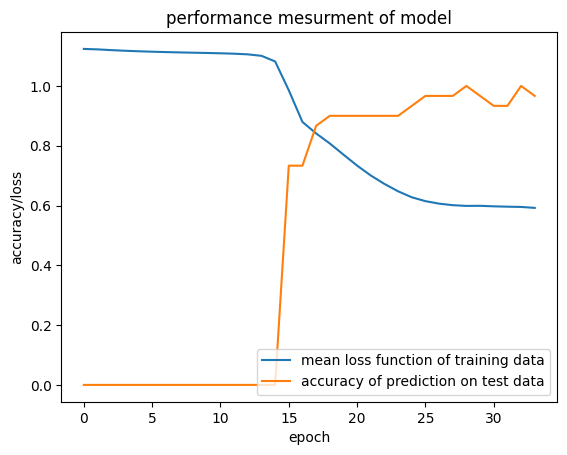

In [456]:
acc = 0.0
for i in range(len(new_dataset)):
    y_pred = model_0(new_dataset[i].float())
    acc += (y_pred.round() == target[i]).all().float()
    #print(acc)
acc = float(acc)/len(new_dataset)
print(f"accuracy on whole dataset: {acc}")

plt.plot(train_history,label="mean loss function of training data")
plt.plot(test_history, label="accuracy of prediction on test data")
plt.legend(loc='lower right')
plt.title("performance mesurment of model")
plt.xlabel("epoch")
plt.ylabel("accuracy/loss")
plt.show()

In [454]:
path = "./irys_model.pth"
torch.save(model_0.state_dict(), path) 